Pseudo-Cl Generation
\begin{aligned}
\text{observed }\tilde{C}( \theta ) =\langle \tilde{T}_{1}(\hat{e})\tilde{T}_{2}(\hat{n}) \rangle ( \theta )\\
\text{masked field }\tilde{T}_{i}(\hat{n}) =M_{i}(\hat{n}) T_{i}(\hat{n})\\
\text{result} \ C( \theta ) =\langle T_{1}(\hat{e}) T_{2}(\hat{n}) \rangle ( \theta )
\end{aligned}

From observation we have masked $\displaystyle \tilde{C}( \theta )$, we could use psuedo-Cl to reconstruct $\displaystyle C( \theta )$,Assuming no cross correlation between TT and MM

\begin{align}
\langle M_{1}(\hat{e}) T_{1}(\hat{e}) M_{2}(\hat{n}) T_{2}(\hat{n}) \rangle ( \theta ) & =\tilde{C}( \theta )\\
\langle M_{1}(\hat{e}) M_{2}(\hat{n}) \rangle ( \theta ) \langle T_{1}(\hat{e}) T_{2}(\hat{n}) \rangle ( \theta ) & =\tilde{C}( \theta )\\
M( \theta ) C( \theta ) & =\tilde{C}( \theta )\\
C( \theta ) & =\frac{\tilde{C}( \theta )}{M( \theta )}
\end{align}

In multipole expansion, we do the legendre transformation on both sides:

\begin{aligned}
C_{l}^{12}( \theta ) & =\frac{2}{2l+1}\int \mathrm{d}\cos \theta \frac{\tilde{C}( \theta )}{M( \theta )} P_{l}(\cos \theta )
\end{aligned}

Here the computation stratergy is:
$\displaystyle M( \theta ) =\sum _{l} C_{l}^{m_{1} m_{2}} P_{l}(\cos \theta ) =idlt\left( C_{l}^{m_{1} m_{2}}\right)( \theta )$

Calculate RHS using fast legendre transform 

\begin{aligned}
C_{l}^{12}( \theta ) & =\frac{2}{2l+1}\int \mathrm{d}\cos \theta \frac{\tilde{C}_{m}^{12}\sum _{m} P_{m}(\cos \theta )}{M( \theta )} P_{l}(\cos \theta )\\
 & =\sum _{m} K_{lm}\tilde{C}_{m}^{12}\\
K_{lm} & =\frac{2}{2l+1}\int \mathrm{d}\cos \theta P_{m}(\cos \theta ) P_{l}(\cos \theta )\frac{1}{M( \theta )}\\
 & =dlt\left(\frac{P_{m}(\cos \theta )}{M( \theta )}\right)_{l}
\end{aligned}


Also for g-g correlation I have $\displaystyle G_{lm}$, for y-y correlation I have $\displaystyle Y_{lm}$

In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.special import eval_legendre as pl
import flt

In [2]:
NSIDE =2048

# Deal with all the masks and weights here

y_mask = hp.read_map('/home/zgd/cmb_y/data/Planck/mask/COM_CompMap_Compton-SZMap-masks_2048_R2.01.fits', field=1)
y_mask_LFI = hp.read_map('/home/zgd/cmb_y/data/Planck/mask/LFI_inpainting_bool.fits', field=0)
y_mask_HFI = hp.read_map('/home/zgd/cmb_y/data/Planck/mask/HFI_inpainting_bool.fits', field=0)

y_mask = y_mask_LFI*y_mask_HFI*y_mask

gal_mask = hp.read_map('/home/zgd/cmb_y/data/unWISE/mask/mask_unWISE_full_v10.fits', field=0)
weight0 = hp.read_map('/home/zgd/cmb_y/data/unWISE/weights/blue_w2_5sig_weights.fits')
weight1 = hp.read_map('/home/zgd/cmb_y/data/unWISE/weights/blue_star_weights.fits')
gal_weights = hp.ud_grade(weight0*weight1,NSIDE)

hdul = fits.open('/home/zgd/cmb_y/data/unWISE/loss/unmaskedareafrac-flag.fits')
gal_loss = hdul[0].data
hdul.close()

In [3]:
lmax=2048
np.seterr(divide='ignore', invalid='ignore')
raw_density = hp.read_map('/home/zgd/cmb_y/data/unWISE/blue/numcounts_map1_2048-r1-v2_flag.fits')
galaxy_density = raw_density*gal_mask*gal_weights/gal_loss
galaxy_density[np.isnan(galaxy_density)] = 0

Cl_mm = hp.anafast(map1=gal_mask,map2=y_mask,lmax=lmax)
Cl_yy_m = hp.anafast(map1=y_mask,lmax=lmax)
Cl_gg_m = hp.anafast(map1=gal_mask,lmax=lmax)

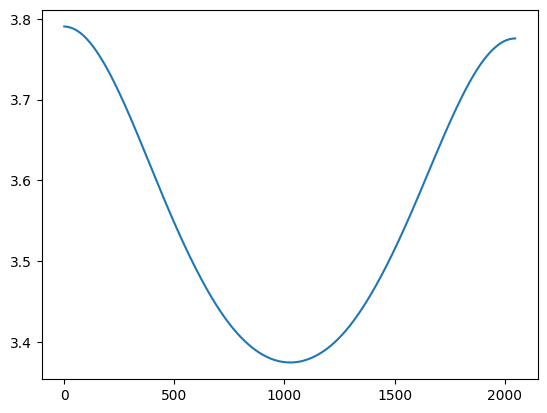

In [19]:
#Turn Cl into angular space

ells = np.arange(0,2049)
C_theta = flt.idlt(Cl_mm)
thetas =flt.theta(2049)
plt.plot(C_theta)



In [20]:
# generate Plq and apply dlt

ls = np.arange(0,2049)
thetas =flt.theta(2049)
ls,thetas = np.meshgrid(ls,thetas)
Plq = pl(ls,np.cos(thetas))


In [21]:
for i in range(2049):
    Plq[i,:]/=C_theta[i]


[ 2.86904782e-01 -2.94802647e-04 -2.04109894e-02 -1.11898391e-04
 -2.07958145e-03 -5.20463466e-05 -7.17543685e-05 -2.94768460e-05
 -3.70856626e-05 -1.20128840e-05]


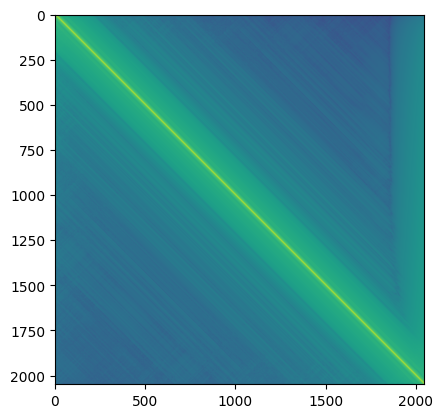

In [22]:
Klm = np.zeros((2049,2049))
for l in range(2049):
    Klm[:,l] = flt.dlt(Plq[:,l])
#save result kernel
np.save('/home/zgd/cmb_y/data/pseudo_cl/mask_Klm.npy',Klm)
print(Klm[0:10,0])
plt.imshow(np.log10(np.abs(Klm)))

In [7]:
Klm = np.load('/home/zgd/cmb_y/data/pseudo_cl/mask_Klm.npy')
Glm = np.load('/home/zgd/cmb_y/data/pseudo_cl/mask_Glm.npy')
Ylm = np.load('/home/zgd/cmb_y/data/pseudo_cl/mask_Ylm.npy')
# Klm/= Klm[0,0]
# Glm/= Glm[0,0]
# Ylm/= Ylm[0,0]

In [28]:
print(Ylm[10,10]/(np.sum(y_mask)/np.shape(gal_mask)[0]))

0.727646956527135


In [29]:
ymap_test_sample = {
                'no_deprojection':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/no_deprojection_standard_full.fits',
                'CIB+CMB_T=10.17beta=1.7':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits'
}
model_colors_test = {
                'no_deprojection':'k',
                'CIB+CMB_T=10.17beta=1.7':'r'
}

In [4]:
y_test = hp.read_map('/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits')

In [5]:
import pymaster as nmt

b = nmt.NmtBin.from_nside_linear(2048, 50)
galaxy_f     = nmt.NmtField(gal_mask, [galaxy_density])
print('g initialized')
y_CMB_CIB_f  = nmt.NmtField(y_mask, [y_test])
print('y CMB CIB f initialized.')
cl_gy_CMB_CIB = nmt.compute_full_master(galaxy_f, y_CMB_CIB_f, b)
print('namaster_done for cl gy')

g initialized
y CMB CIB f initialized.
namaster_done for cl gy


In [6]:
cl_gy_anafast = hp.anafast(galaxy_density*gal_mask,y_test*y_mask)

NameError: name 'Klm' is not defined

In [10]:
cl_gy_pseudo = np.dot(Klm,cl_gy_anafast[:2049])

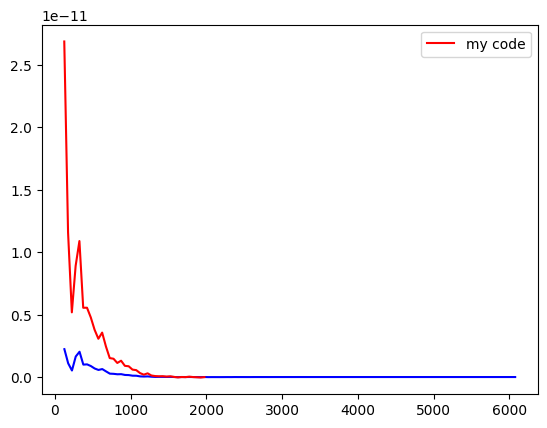

In [29]:
lmax=2000
bin=50
ell_arr = b.get_effective_ells()
plt.plot(ell_arr[2:], cl_gy_CMB_CIB[0,2:],c='b')
cl_gy_psuedo_binned = np.sum(np.reshape(cl_gy_pseudo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
ll = np.arange(lmax//bin)*bin+0.5*bin
plt.plot(ll[2:],cl_gy_psuedo_binned[2:],c='r',label = 'my code')
plt.legend()

In [18]:
ymap_path_dict_sample = {
                'no_deprojection':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/no_deprojection_standard_full.fits',
                'CIB+CMB_T=10.17beta=1.7':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/deproject_CMB_CIB_default_standard_full.fits',
                'CIB+CMB_T=24beta=1.0':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED/deproject_CMB_CIB_beta1.0_T24_standard_full.fits',
                'CIB+CMB_T=24beta=1.4':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T24_standard_full.fits',
                'CIB+CMB_T=10.14beta=1.4':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED/deproject_CMB_CIB_beta1.4_T10.14_standard_full.fits',
                'CIB+CMB_T=10.14beta=1.6':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED/deproject_CMB_CIB_beta1.6_T10.14_standard_full.fits'}
model_colors = {'no_deprojection':'k',
                'CIB+CMB_T=10.17beta=1.7':'r',
                'CIB+CMB_T=24beta=1.0':'b',
                'CIB+CMB_T=24beta=1.4':'g',
                'CIB+CMB_T=10.14beta=1.4':'c',
                'CIB+CMB_T=10.14beta=1.6':'y'}

In [17]:
ymap_path_dict_CIB_dbeta = {
                'no_deprojection':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/no_deprojection_standard_full.fits',
                'CMB+CIB+CIBdbeta_T=10.17beta=1.7':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_default_standard_full.fits',
                'CMB+CIB+CIBdbeta_T=24beta=1.0':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbeta/deproject_CMB5_CIB_CIBdbeta_beta1.0_T24_standard_full.fits',
                'CMB+CIB+CIBdbeta_T=24beta=1.4':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbeta/deproject_CMB5_CIB_CIBdbeta_beta1.4_T24_standard_full.fits',
                'CMB+CIB+CIBdbeta_T=10.14beta=1.4':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbeta/deproject_CMB5_CIB_CIBdbeta_beta1.4_T10.14_standard_full.fits',
                'CMB+CIB+CIBdbeta_T=10.14beta=1.6':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbeta/deproject_CMB5_CIB_CIBdbeta_beta1.6_T10.14_standard_full.fits'}

model_colors_CIB_debeta = {'no_deprojection':'k',
                'CMB+CIB+CIBdbeta_T=10.17beta=1.7':'r',
                'CMB+CIB+CIBdbeta_T=24beta=1.0':'b',
                'CMB+CIB+CIBdbeta_T=24beta=1.4':'g',
                'CMB+CIB+CIBdbeta_T=10.14beta=1.4':'c',
                'CMB+CIB+CIBdbeta_T=10.14beta=1.6':'y'}


In [28]:
ymap_path_dict_CIB_dbeta_dT = {
                'no_deprojection':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/no_deprojection_standard_full.fits',
                'CMB+CIB+CIBdbetadT_T=10.17beta=1.7':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/deproject_CMB5_CIB_CIBdbeta_CIBdT_default_standard_full.fits',
                'CMB+CIB+CIBdbetadT_T=24beta=1.0':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbetadT/deproject_CMB5_CIB_CIBdbeta_CIBdT_beta1.0_T24_standard_full.fits',
                'CMB+CIB+CIBdbetadT_T=24beta=1.4':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbetadT/deproject_CMB5_CIB_CIBdbeta_CIBdT_beta1.4_T24_standard_full.fits',
                'CMB+CIB+CIBdbetadT_T=10.14beta=1.4':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbetadT/deproject_CMB5_CIB_CIBdbeta_CIBdT_beta1.4_T10.14_standard_full.fits',
                'CMB+CIB+CIBdbetadT_T=10.14beta=1.6':'/media/zgd/T7 Shield/data/CMB_ymap/Planck/ymap/SED_dbetadT/deproject_CMB5_CIB_CIBdbeta_CIBdT_beta1.6_T10.14_standard_full.fits'}

model_colors_CIB_debeta_dT = {'no_deprojection':'k',
                'CMB+CIB+CIBdbetadT_T=10.17beta=1.7':'r',
                'CMB+CIB+CIBdbetadT_T=24beta=1.0':'b',
                'CMB+CIB+CIBdbetadT_T=24beta=1.4':'g',
                'CMB+CIB+CIBdbetadT_T=10.14beta=1.4':'c',
                'CMB+CIB+CIBdbetadT_T=10.14beta=1.6':'y'}

anafast for galaxy density map
reading y map forno_deprojection
generating pseudo Cl for no-deprojection
reading y map forCIB+CMB_T=10.17beta=1.7
generating pseudo Cl for no-deprojection
reading y map forCIB+CMB_T=24beta=1.0
generating pseudo Cl for no-deprojection
reading y map forCIB+CMB_T=24beta=1.4
generating pseudo Cl for no-deprojection
reading y map forCIB+CMB_T=10.14beta=1.4
generating pseudo Cl for no-deprojection
reading y map forCIB+CMB_T=10.14beta=1.6
generating pseudo Cl for no-deprojection


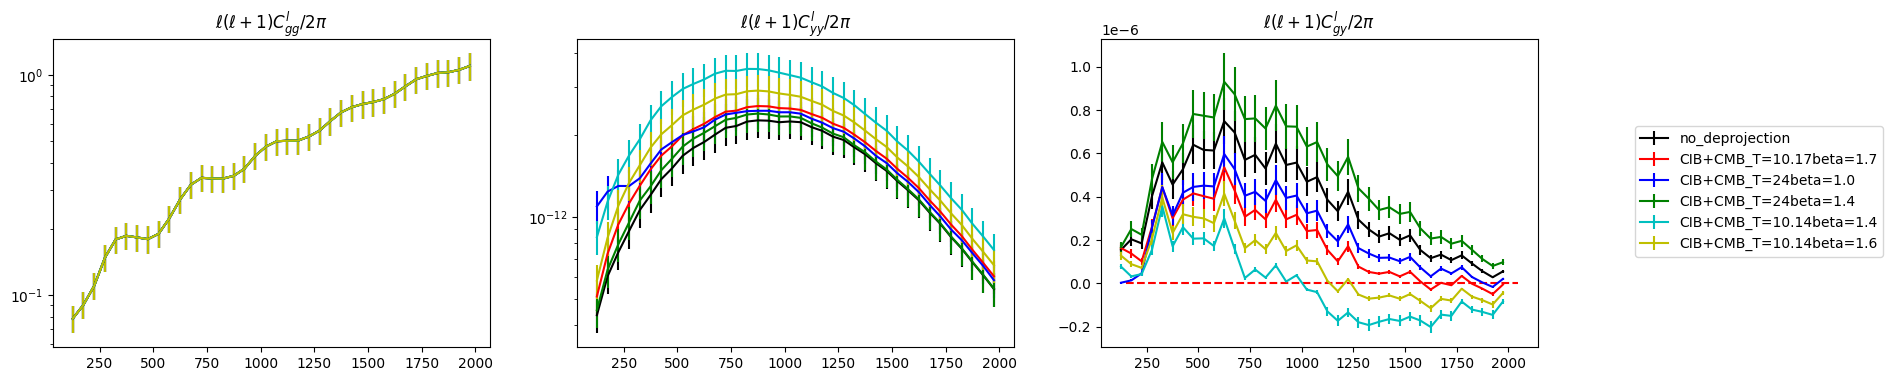

In [35]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
omit = 2
lmax = 2048
bin = 50

ll = np.arange(lmax//bin)*bin+0.5*bin
pll = ll*(ll+1)/2/np.pi

f_sky = np.sum(y_mask*gal_mask)/len(y_mask)

print('anafast for galaxy density map')

f_sky_gal = np.sum(gal_mask)/np.shape(gal_mask)[0]
f_sky_y = np.sum(y_mask)/np.shape(y_mask)[0]
f_sky_gy = np.sum(y_mask*gal_mask)/np.shape(y_mask)[0]

Cl_gg = hp.anafast(galaxy_density*gal_mask,lmax=lmax)/f_sky_gal

for model,path in ymap_path_dict_sample.items():
    print('reading y map for'+model)
    y_map = hp.read_map(path)
    Cl_gy = hp.anafast(map1=galaxy_density*gal_mask,map2=y_map*y_mask,lmax=lmax)/f_sky_gy
    Cl_yy = hp.anafast(y_map*y_mask,lmax=lmax)/f_sky_y

    print('generating pseudo Cl for no-deprojection')
    Cl_gg_psuedo = np.dot(Glm,Cl_gg)
    Cl_yy_psuedo = np.dot(Ylm,Cl_yy)
    Cl_gy_psuedo = np.dot(Klm,Cl_gy)

    Cl_gg_psuedo_binned = np.sum(np.reshape(Cl_gg_psuedo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    Cl_yy_psuedo_binned = np.sum(np.reshape(Cl_yy_psuedo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    Cl_gy_psuedo_binned = np.sum(np.reshape(Cl_gy_psuedo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    
    Cl_gg_psuedo_binned_std = np.sum(np.reshape(Cl_gg_psuedo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    Cl_yy_psuedo_binned_std = np.sum(np.reshape(Cl_yy_psuedo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    Cl_gy_psuedo_binned_std = np.sum(np.reshape(Cl_gy_psuedo[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    
    #Cl_gg_binned = np.sum(np.reshape(Cl_gg[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    #Cl_yy_binned = np.sum(np.reshape(Cl_yy[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)
    #Cl_gy_binned = np.sum(np.reshape(Cl_gy[0:(lmax+1)//bin*bin],((lmax+1)//bin,bin)),axis=1)

    sigma_gg_psuedo_binned = np.sqrt(2*Cl_gg_psuedo_binned**2/(bin*(2*ll+1))+Cl_gg_psuedo_binned_std**2/bin)
    sigma_yy_psuedo_binned = np.sqrt(2*Cl_yy_psuedo_binned**2/(bin*(2*ll+1))+Cl_yy_psuedo_binned_std**2/bin)
    sigma_gy_psuedo_binned = np.sqrt((Cl_yy_psuedo_binned*Cl_gg_psuedo_binned+Cl_gy_psuedo_binned**2)/(bin*(2*ll+1)*f_sky)+Cl_gy_psuedo_binned_std**2/bin)

    ax[0].errorbar(ll[omit:],pll[omit:]*Cl_gg_psuedo_binned[omit:],yerr=pll[omit:]*sigma_gg_psuedo_binned[omit:],label=model,c=model_colors[model])
    ax[1].errorbar(ll[omit:],pll[omit:]*Cl_yy_psuedo_binned[omit:],yerr=pll[omit:]*sigma_yy_psuedo_binned[omit:],c=model_colors[model])
    ax[2].errorbar(ll[omit:],pll[omit:]*Cl_gy_psuedo_binned[omit:],yerr=pll[omit:]*sigma_gy_psuedo_binned[omit:],c=model_colors[model])

    #ax[0].errorbar(ll[omit:],pll[omit:]*Cl_gg_binned[omit:],yerr=pll[omit:]*sigma_gg_psuedo_binned[omit:],ls='--',c=model_colors_CIB_debeta[model])
    #ax[1].errorbar(ll[omit:],pll[omit:]*Cl_yy_binned[omit:],yerr=pll[omit:]*sigma_yy_psuedo_binned[omit:],ls='--',c=model_colors_CIB_debeta[model])
    #ax[2].errorbar(ll[omit:],pll[omit:]*Cl_gy_binned[omit:],yerr=pll[omit:]*sigma_gy_psuedo_binned[omit:],ls='--',c=model_colors_CIB_debeta[model])

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_title('$\\ell(\\ell+1)C^{l}_{gg}/2\\pi$')
ax[1].set_title('$\\ell(\\ell+1)C^{l}_{yy}/2\\pi$')
ax[2].set_title('$\\ell(\\ell+1)C^{l}_{gy}/2\\pi$')
ax[2].hlines(0,150,2048,color='r',linestyle='--')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.subplots_adjust(right = 0.95)
fig.savefig("./output/pseudocl.png",dpi=400)

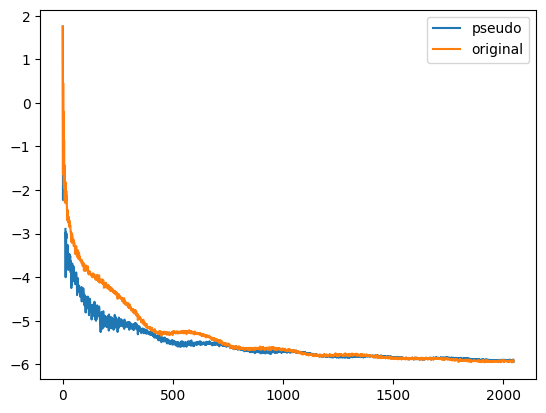

In [21]:
Cl_gg_psu = np.dot(Glm,Cl_gg)

plt.plot(np.log10(Cl_gg_psu),label='pseudo')
plt.plot(np.log10(Cl_gg),label='original')
plt.legend()